In [2]:
import numpy as np
import xarray as xr
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import pickle
from matplotlib import gridspec
import alexas_functions 
alexas_functions.list_my_functions()

the available functions are: 
list_my_functions
test_function
get_filename
get_landsea_mask
extract_region
cc_ev
mask_out_regions
reshape
get_PC_components
dump_into_pickle
open_pickle_data
zonal_avg
Fourier_Analysis
:end of list.


In [2]:
def lat_analysis(daatype, var, exp='historical', omtype='model',
                 lat_band_size=180, first_ensm_inloop= 1, end_ensm_inloop= 101, 
                 timeper1= slice('1945', '1974'), timeper2= slice('1990', '2019'), 
                 opt='no_mask', input_mask=None):
    
    ## number of latitude bands, 180 deg / size of lat bands
    num_bands = 180/lat_band_size
    
    ## generate list of latitude coordinates given lat_band_size
    latlist = np.arange(-90,90+lat_band_size,lat_band_size)

    
    ## data array: first dim= num of ensm members, sec dim= num of lat bands, third= fourier data
    ensm_lat_analysis = np.zeros(( int(end_ensm_inloop - first_ensm_inloop), int(num_bands), 10)) 
    
    ######## loop through ensemble members ########
    for ensm in range(first_ensm_inloop, end_ensm_inloop): #(1,101)
        print(ensm, end=': ') 
        
        d1t_filenames = []
        d1t_filenames.append(alexas_functions.get_filename(daatype, var, r=ensm, omtype=omtype))
        if daatype=='mpi_ensm':
            d1t_filenames.append( alexas_functions.get_filename(daatype, var, r=ensm, exp='rcp85'))
        
        ## OPEN
        d1 = xr.open_mfdataset(d1t_filenames)
        

        ### MASKING
        if opt=='no_mask':
            d1t = d1[var]
        elif opt=='mask':    
            d1t = d1[var]*input_mask
                 
        d1t = alexas_functions.uniform_coords(d1t, ['latitude', 'longitude'], ['lat','lon'])
                
        d1.close()
        
        ## generate data storage array for one ensemble member
        lat_analysis_1 = np.zeros((int(num_bands),10))


        ###### loop through the latitude coordinates list ######
        for l in range(0, len(latlist)-1):
            print(latlist[l], latlist[l+1], end = ', ')
            
            ## send xarray data of given ensemble member to be zonally average in the lat band                
            d1_latloop = alexas_functions.zonal_avg(d1t, latlist[l], latlist[l+1])   
            
            
            ## get 30 year averages of the zonally averaged data , take the difference 
            latloop_per1 = d1_latloop.sel(time=timeper1).groupby('time.month').mean()
            latloop_per2 = d1_latloop.sel(time=timeper2).groupby('time.month').mean()
            latloop_diff = ( latloop_per2 - latloop_per1 ).values
            
            ## send to Fourier code , returns Fourier data 
            diff_fourier = alexas_functions.Fourier_Analysis(latloop_diff) 
            
            ## plug into single ensemble data storage array 
            lat_analysis_1[l][0] = ensm
            lat_analysis_1[l][1:3] = latlist[l], latlist[l+1]
            lat_analysis_1[l][3:] = diff_fourier
            ###### end of latitude loop ######
            
        ## plug in to full ensemble data storage 
        ensm_lat_analysis[ensm-first_ensm_inloop] = lat_analysis_1 
        print('done.')
        
        ###### end of ensemble loop ######
    #clear_output()
    print('complete!')
    return ensm_lat_analysis
## EXAMPLE
## had_all = lat_analysis(lat_band_size= 10,            
## first_ensm_inloop= 1, end_ensm_inloop= 101,  timeper1=slice('1945', '1974'),  opt='all', datat='obs')
       

In [3]:
mpi_lat = lat_analysis('mpi_ensm', 'tas', end_ensm_inloop=11)

1: -90 90, done.
2: -90 90, done.
3: -90 90, 

KeyboardInterrupt: 

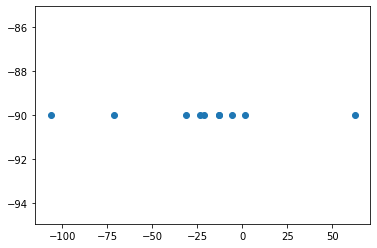

In [14]:
plt.scatter(mpi_lat[:,0, 5], mpi_lat[:,0, 1])

In [3]:
alexas_functions.get_filename('can_ensm', 'tas', r=12)

'C:\\Users\\alexa\\Documents\\RESEARCH\\DATA\\can_ensm\\tas\\tas_Amon_CanESM2_historical-r2_r2i1p1_195001-202012.nc'